In [1]:
import os
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

from tqdm.notebook import tqdm



DATA_DIR = "data" # This may need to be changed on different machines
# Make sure we're in the correct directory and make sure the data directory exists
if not os.path.exists(DATA_DIR):
    os.chdir("../..") # Move up two directories because we're in src/nb and the data directory/path should be in/start at the root directory 
    assert os.path.exists(DATA_DIR), f"ERROR: DATA_DIR={DATA_DIR} not found"  # If we still can't see the data directory something is wrong

# Code largely from the [example code on hugging face](https://huggingface.co/sentence-transformers/all-mpnet-base-v2)

In [2]:
def hexbin_plot(x, y, labels):
    types = set(labels)

    n = len(types)
    sqrt_n = np.sqrt(n)
    if sqrt_n % 1 == 0:
        r, c = sqrt_n, sqrt_n
    else:
        r, c = int(sqrt_n) + 1, int(sqrt_n)

    fig, axes = plt.subplots(r,c, figsize=(c*3, r*3))

    axes = axes.flatten()
    for i, label in enumerate(types):
        inds = np.where(labels == label)[0]
        axes[i].hexbin(x[inds], y[inds], gridsize=20)
        axes[i].set_title(label)
        axes[i].set_xticks([]), axes[i].set_yticks([])

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')
model = model.to(device)

In [4]:
cds = load_dataset("billray110/corpus-of-diverse-styles", use_auth_token=True)
cds

Using custom data configuration billray110--corpus-of-diverse-styles-86c527f26971c5cb
Reusing dataset csv (/home/bill/.cache/huggingface/datasets/csv/billray110--corpus-of-diverse-styles-86c527f26971c5cb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    validation: Dataset({
        features: ['label', 'text', 'paraphrase'],
        num_rows: 393727
    })
})

In [5]:
def tokenize(batch):
    return tokenizer(batch, padding=True, truncation=True, return_tensors="pt")

encoded_paraphrase = tokenize(cds["validation"]["paraphrase"])
encoded_paraphrase

{'input_ids': tensor([[    0,  2003,  2464,  ...,     1,     1,     1],
        [    0,  1049,  2249,  ...,     1,     1,     1],
        [    0,  2006,  2250,  ...,     1,     1,     1],
        ...,
        [    0,  1049,  1009,  ...,     1,     1,     1],
        [    0,  1049,  1009,  ...,     1,     1,     1],
        [    0,  8103, 12407,  ...,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [6]:
# Compute token embeddings
inputs = {
    "input_ids": encoded_paraphrase["input_ids"],
    "attention_mask": encoded_paraphrase["attention_mask"]
}
all_sentence_embeddings = []
batch_size = 512
with torch.no_grad():
    for i in tqdm(range(0, len(encoded_paraphrase["input_ids"]), batch_size)):
        input_ids = encoded_paraphrase["input_ids"][i:i+batch_size].to(device)
        attention_mask = encoded_paraphrase["attention_mask"][i:i+batch_size].to(device)

        batch_output = model(input_ids, attention_mask)

        # Perform pooling
        sentence_embeddings = mean_pooling(batch_output, attention_mask)

        # Normalize embeddings
        sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

        # take the sentence embeddings off the GPU
        sentence_embeddings = sentence_embeddings.cpu()

        # Append to list
        all_sentence_embeddings.append(sentence_embeddings)

# Concatenate all embeddings
sentence_embeddings = torch.cat(all_sentence_embeddings, dim=0)

# Embedding Shape
print(f"Sentence Embeddings Shape: {sentence_embeddings.shape}")

  0%|          | 0/769 [00:00<?, ?it/s]

Sentence Embeddings Shape: torch.Size([393727, 768])


In [8]:
# save the embeddings as npy
np.save("data/paraphrase_embeddings.npy", sentence_embeddings.numpy())

In [9]:
# load the embeddings
sentence_embeddings = np.load("data/paraphrase_embeddings.npy")

In [ ]:
# project the sentence emebeddings to 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(sentence_embeddings.numpy())

# visualize the embeddings
plt.figure(figsize=(16, 10))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1])

# save the plot
plt.savefig("data/sentence_embeddings.png")

plt.show()


In [ ]:
# use pca to reduce the dimensionality of the embeddings to 2D

pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(sentence_embeddings)

# save pca embeddings
np.save("data/pca_embeddings.npy", pca_embeddings)

hexbin_plot(pca_embeddings[:, 0], pca_embeddings[:, 1], np.array(cds["validation"]["label"]))
plt.savefig("data/pca_hexbin.png", facecolor="white")
plt.show()

In [ ]:
# save tsne_embeddings as npy
np.save("data/tsne_embeddings.npy", tsne_embeddings)

In [ ]:
tsne_embeddings.shape

In [ ]:

plt.figure(figsize=(16, 10))
# plot the tsne embeddings and color them by the labels
# random color

labels_to_color = {k:np.random.random(size=3) for k in set(cds["validation"]["label"])}



random_inds = np.random.choice(len(pca_embeddings), size=100000, replace=False).astype(int)
random_embeddings = pca_embeddings[random_inds]
random_labels = np.array(cds["validation"]["label"])[random_inds]

colors = list(map(lambda x: labels_to_color[x], random_labels))

for label in set(cds["validation"]["label"]):
    inds = np.where(random_labels == label)[0]
    plt.scatter(random_embeddings[inds, 0], random_embeddings[inds, 1], label=label)

plt.legend()

# save the plot
plt.savefig("data/sentence_embeddings.png")

plt.show()

In [10]:


scaled_embeddings = MinMaxScaler().fit_transform(sentence_embeddings)
mapper = UMAP(n_components=2, metric="cosine").fit(scaled_embeddings)

df_emb = pd.DataFrame(mapper.embedding_, columns=["x", "y"])
df_emb["label"] = cds["validation"]["label"]
df_emb.head()

,x,y,label
0,7.443198,10.965001,joyce
1,1.937541,10.987344,joyce
2,3.836359,11.561824,joyce
3,5.785924,8.555490,joyce
4,4.239930,9.747719,joyce


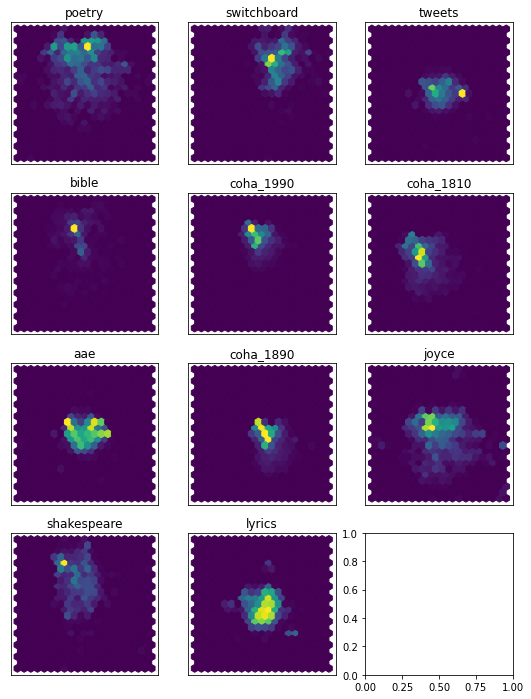

In [11]:
hexbin_plot(df_emb["x"], df_emb["y"], df_emb["label"])
plt.savefig("data/umap_hexbin.png", facecolor="white")
plt.show()

In [12]:
# train a linear classifier on the embeddings
embedding_dim = sentence_embeddings.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

linear_layer = nn.Linear(embedding_dim, 11).to(device)

string_labels = np.array(cds["validation"]["label"])
label_to_int = {k:i for i, k in enumerate(set(string_labels))}
# integer labels
int_labels = np.array(list(map(lambda x: label_to_int[x], string_labels)))

shuffled_inds = np.random.choice(len(int_labels), size=len(int_labels), replace=False).astype(int)

train_inds = shuffled_inds[:int(len(int_labels) * 0.8)]
val_inds = shuffled_inds[int(len(int_labels) * 0.8):]

optimizer = torch.optim.Adam(linear_layer.parameters(), lr=0.001)

batch_size = 512


In [14]:
for epoch in range(25):
    loss_ewma = 0
    loss_count = 0
    pbar = tqdm(range(0, len(train_inds), batch_size))
    for batch in pbar:
        inds = train_inds[batch:batch+batch_size]

        batch_embeddings = sentence_embeddings[inds]
        batch_labels = int_labels[inds]

        batch_embeddings = torch.from_numpy(batch_embeddings).to(device)
        batch_labels = torch.from_numpy(batch_labels).to(device)

        batch_output = linear_layer(batch_embeddings)

        loss = F.cross_entropy(batch_output, batch_labels)
        loss_count += 1

        loss_ewma = loss_ewma * 0.9 + loss * 0.1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update pbar
        pbar.set_description(f"Epoch {epoch} Loss: {loss_ewma.item():.4f}")

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

In [15]:
# evaluate the model
val_embeddings = torch.from_numpy(sentence_embeddings[val_inds]).to(device)
preds = linear_layer(val_embeddings).argmax(dim=1)
val_labels = torch.from_numpy(int_labels[val_inds]).to(device)
acc = (preds == val_labels).float().mean()
print(f"Validation accuracy: {acc.item():.4f}")


Validation accuracy: 0.7703


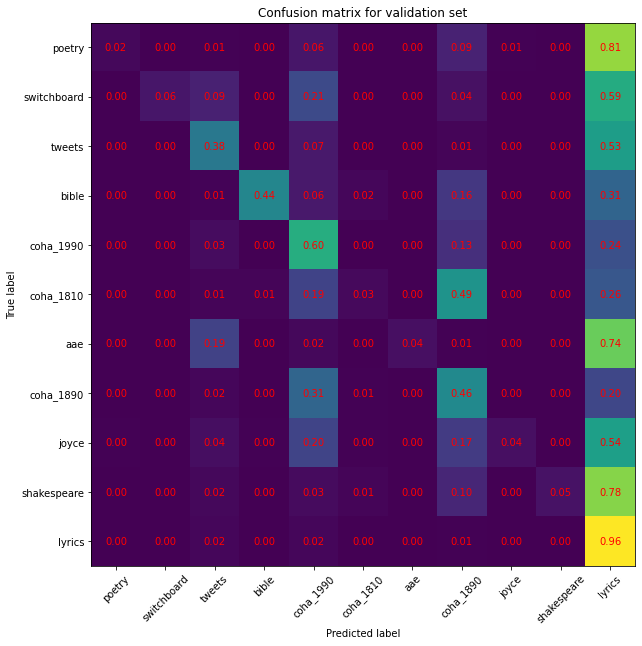

In [17]:
# plot of a confusion matrix

y_true = val_labels.cpu().numpy()
y_pred = preds.cpu().numpy()

classes = list(set(y_true))

conf_mat = np.zeros((len(classes), len(classes)))
for r in range(len(classes)):
    for c in range(len(classes)):
        conf_mat[r, c] = ((y_true == classes[r]) & (y_pred == classes[c])).sum()

conf_mat /= conf_mat.sum(axis=1, keepdims=True)
# conf_mat /= conf_mat.sum() * 0.01

# plot the matrix
plt.figure(figsize=(16, 10))
plt.imshow(conf_mat)

# Draw the values inside the matrix
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, f"{conf_mat[i, j]:.2f}", ha="center", va="center", color="red")


plt.xticks(np.arange(len(classes)), set(string_labels), rotation=45)
plt.yticks(np.arange(len(classes)), set(string_labels))
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title(f"Confusion matrix for validation set")
plt.savefig("data/confusion_matrix.png", facecolor="white")
plt.show()

poetry: 1464
switchboard: 1487
tweets: 39662
bible: 1714
coha_1990: 48985
coha_1810: 5340
aae: 7316
coha_1890: 32024
joyce: 2054
shakespeare: 1313
lyrics: 252368


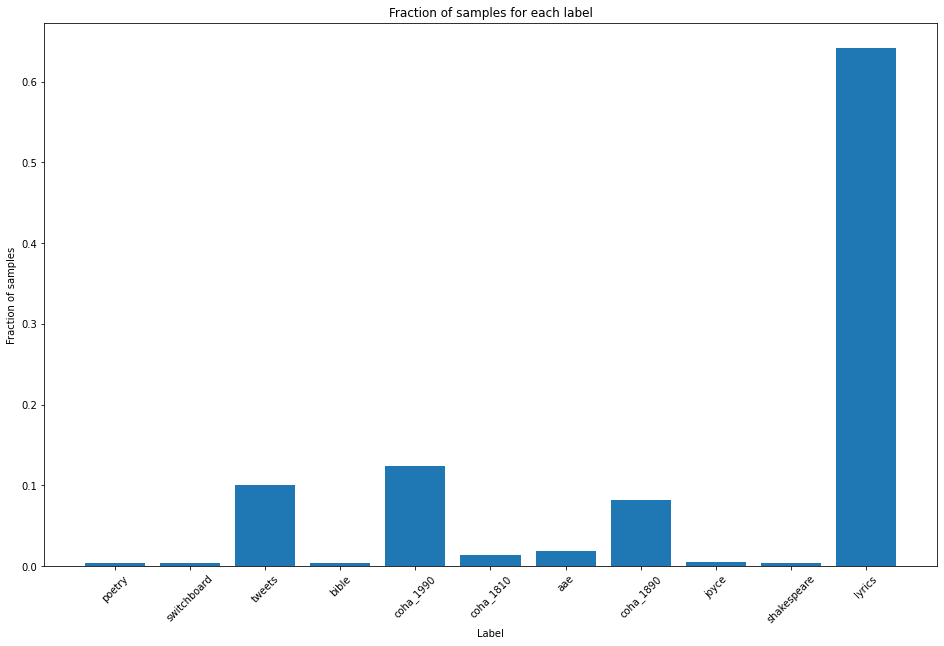

In [18]:
# print the total label counts for each class
for label in set(string_labels):
    print(f"{label}: {(string_labels == label).sum()}")

# Make a bar graph of the label counts
plt.figure(figsize=(16, 10))
plt.bar(np.arange(len(classes)), [(string_labels == label).sum()/len(string_labels) for label in set(string_labels)])
plt.xticks(np.arange(len(classes)), set(string_labels), rotation=45)
plt.ylabel("Fraction of samples")
plt.xlabel("Label")
plt.title(f"Fraction of samples for each label")
plt.savefig("data/label_counts.png", facecolor="white")
plt.show()
